# MSAI BH Sim Exploration
Members: Jack, Arjun, Ruchi

In [1]:
%load_ext autoreload
%autoreload 2
%run -i harmpi/harm_script.py

In [2]:
from utils.utils import read_dump_util

# NOTE read_dump_util replaces rd('dump000') for msai code

dump_name = 'dump000'
_, dump_dict = read_dump_util(dump=dump_name)
t = dump_dict['t']
print(f'The time associated with {dump_name} is: {t}')

The time associated with dump000 is: 0.0


In [3]:
# reads all dumps in file system
import os
import re

dumps = []
for filename in os.listdir('harmpi/dumps'):
    if re.match(r'^dump\d+$', filename):
        dumps.append(filename)
dumps.sort()
num_dumps = len(dumps)
print(f'Number of Dumps: {num_dumps}')


Number of Dumps: 29


In [4]:
# translate dump data into tensors
import torch

# TODO make dataset
data = []
for dump in dumps:
    _, dump_dict = read_dump_util(dump=dump)

    # rd(dump)
    rho = dump_dict['rho']
    ug = dump_dict['ug']
    uu = dump_dict['uu']
    B = dump_dict['B']

    rho_tensor = torch.tensor(rho).squeeze(2).unsqueeze(0)
    ug_tensor = torch.tensor(ug).squeeze(2).unsqueeze(0)
    uu_tensor = torch.tensor(uu[1:4]).squeeze(3)
    B_tensor = torch.tensor(B[1:4]).squeeze(3)
    
    data_tensor = torch.cat((rho_tensor, ug_tensor, uu_tensor, B_tensor), dim=0)
    data.append(data_tensor.unsqueeze(0))

data = torch.cat(data, dim=0)
print(f'Shape of the dataset: {data.shape}')

Shape of the dataset: torch.Size([29, 8, 128, 128])


In [ ]:
# make prediction dataloaders
from torch.utils.data import Dataset, DataLoader, random_split

class PredictionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)-1

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.dataset[idx+1]
        return data, label

# 
def make_prediction_dataloaders(batch_size: int = 8):
    loaded_data = PredictionDataset(data)
    train_size = int(0.7 * len(loaded_data))
    val_size = int(0.15 * len(loaded_data))
    test_size = len(loaded_data) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(loaded_data, [train_size, val_size, test_size])

    # create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_prediction_dataloaders()


In [ ]:
from models.ffnn.ffnn import FFNN, train_ffnn

# initialize net
net = FFNN(
    input_dim = 8*128*128,
    version_str = 'v0.0.0'
)

# train net
losses = train_ffnn(
    model = net,
    epochs = 25,
    train_loader = train_loader,
    valid_loader = val_loader,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
net.save()



In [ ]:
# load model state dictionary
net = FFNN(input_dim = 8*128*128)
net.load_state_dict(torch.load(f'models/ffnn/saves/ffnn_v0.0.0.pth', weights_only=True))

In [ ]:
from utils.anim import animate_comparison

# structure dumps data for animation
def make_ground_truth_frames():
    ground_truths = []
    for dump in dumps:
        _, dump_dict = read_dump_util(dump=dump)
        ground_truth_array = dump_dict['rho'][:,:,0].transpose()
        ground_truth_array = np.log10(ground_truth_array)
        ground_truths.append(ground_truth_array)

    return ground_truths

# run FFNN from starting dump for length of dumps
# returns formatted predictions 
def make_prediciton_frames(first_frame: torch.Tensor, num_frames: int):
    # helper for adding formatted frame to predictions array
    def postprocess_and_add(predictions: list, frame: torch.Tensor):
        # format tensor to array for animation
        # NOTE ugliest thing ever please fix
        # NOTE second 0 means rho!
        frame_array = frame[0][0].unsqueeze(-1).detach().numpy()[:,:,0].transpose()
        
        # NOTE transform 
        frame_array = np.log10(frame_array)
        
        predictions.append(frame_array)

    net.eval()
    # get first datapoint
    frame = first_frame
    predictions = []
    batch_len = 1
    # create prediction list
    for frame_num in range(num_frames):
        # copy and postprocess frame, add to predictions
        postprocess_and_add(predictions=predictions, frame=frame.clone().detach())
        # reshape for network
        frame_reshaped = torch.reshape(frame, (batch_len,8*128*128))
        # forward pass
        raw_frame = net.forward(frame_reshaped)
        # reshape for animation
        frame = torch.reshape(raw_frame, (batch_len,8,128,128))

    return predictions

# 
ground_truths = make_ground_truth_frames()

# 
predictions = make_prediciton_frames(first_frame=data[0].unsqueeze(0), num_frames=len(dumps))

# animate
animate_comparison(
    ground_truths = ground_truths, 
    predictions = predictions, 
    save_path = './movies/movie.gif',
    cb = True
)


In [7]:
# make encoding dataloaders
from torch.utils.data import Dataset, DataLoader, random_split

class EncodingDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)-1

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.dataset[idx]
        return data, label

# 
def make_encoding_dataloaders(data, batch_size: int = 8):
    loaded_data = EncodingDataset(data)
    train_size = int(0.7 * len(loaded_data))
    val_size = len(loaded_data) - train_size
    train_dataset, val_dataset = random_split(loaded_data, [train_size, val_size])

    # create DataLoaders for each split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


train_loader, val_loader = make_encoding_dataloaders(data=data)


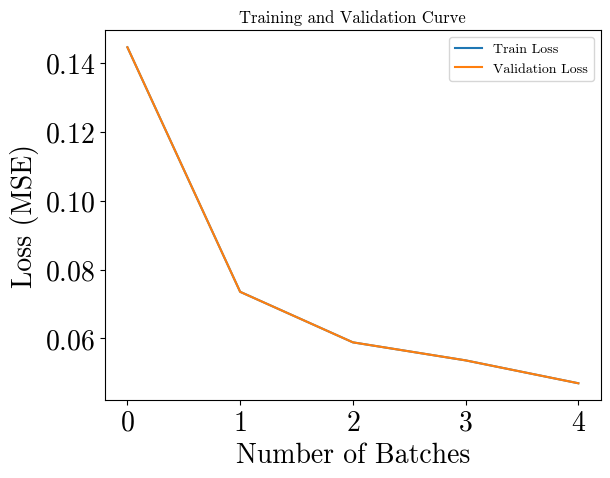

Saved model as models/ffnn/saves/ae_v0.0.0.pth


In [10]:
from models.ffnn.ffnn import AE, train_ffnn

# initialize net
ae = AE(
    input_dim = 8 * 128 * 128,
    latent_dim = 3 * 10 * 10,
    version_str = 'v0.0.0'
)

# train net
losses = train_ffnn(
    model = ae,
    epochs = 5,
    train_loader = train_loader,
    valid_loader = val_loader,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
ae.save()